In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    TOML_PATH,
    DATA_PATH,
    BUILD_DIR,
)


COLUMNS = ["participant", "compound_position", "compound_charge_params"]


In [2]:
src = os.path.join(BUILD_DIR, "inference.pkl")
with open(src, "rb") as f:
    COMBINED_COMBINATIONS, COMBINED_POSTERIOR_SAMPLES = pickle.load(f)

DATA = pd.read_csv(DATA_PATH)
print(DATA.shape)

config = Config(TOML_PATH)
model = NonHierarchicalBayesianModel(config)


(16440, 44)


2024-07-13 21:29:14.870707: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


### L - M

In [3]:
combinations = [
    c for c in COMBINED_COMBINATIONS if (
        # Remove 80-0-20-400 charge
        c[2] != "80-0-20-400" and
        # Remove ground contacts
        "" not in c[1].split("-") and
        # At the same segment
        c[1].split("-")[0][:-1] == c[1].split("-")[1][:-1]
    )
]

combinations;

ind = [c in combinations for c in COMBINED_COMBINATIONS]
posterior_samples = {
    u: v[:, ind, ...] for u, v in COMBINED_POSTERIOR_SAMPLES.items()
}


In [4]:
# map_to_subjects = {}
# for subject, position, charge in combinations:
#     orientation = [u[-1] for u in position.split("-")]
#     orientation = "-".join(orientation)
#     # print(orientation)

#     segment = position.split("-")[0][:-1]
#     assert segment == position.split("-")[1][:-1]
#     # print(segment)

#     if orientation not in map_to_subjects:
#         map_to_subjects[orientation] = {
#             segment: {
#                 charge: [subject]
#             }
#         }
#     else:
#         if segment not in map_to_subjects[orientation]:
#             map_to_subjects[orientation][segment] = {
#                 charge: [subject]
#             }
#         else:
#             if charge not in map_to_subjects[orientation][segment]:
#                 map_to_subjects[orientation][segment][charge] = [subject]
#             else:
#                 map_to_subjects[orientation][segment][charge].append(subject)

#     # if position not in map_to_subjects:
#     #     map_to_subjects[position] = {charge: [subject]}
#     # else:
#     #     if charge not in map_to_subjects[position]:
#     #         map_to_subjects[position][charge] = [subject]
#     #     else:
#     #         map_to_subjects[position][charge].append(subject)

#     # map_to_subjects[position][charge] = sorted(map_to_subjects[position][charge])

# map_to_subjects;


In [13]:
directions = ["L-M", "M-L"]
segments = ["C6", "C7", "C8"]
charges = ['20-0-80-25', '50-0-50-0', '50-0-50-100']
subjects = sorted(DATA["participant"].unique().tolist())

a = None
a_mask = None

for subject in subjects:
    for direction in directions:
        for segment in segments:
            for charge in charges:
                compound_position = f"{segment}{direction[:-1]}{segment}{direction[-1]}"
                curr_combination = (subject, compound_position, charge)
                if curr_combination in combinations:
                    ind = [c == curr_combination for c in combinations]
                    assert sum(ind) == 1
                    if a is None:
                        a = posterior_samples[site.a][:, ind, ...]
                    else: a = np.concatenate([a, posterior_samples[site.a][:, ind, ...]], axis=1)
                else:
                    if a is None:
                        a = np.zeros()



In [21]:
posterior_samples[site.a][:, ind, ...].shape

(4000, 1, 6)

In [19]:
8 * 2 * 3 * 3

144

In [18]:
a.reshape(-1, len(subjects), len(directions), len(segments), len(charges), *a.shape[2:])


ValueError: cannot reshape array of size 2304000 into shape (8,2,3,3,6)

In [14]:
a.shape

(4000, 96, 6)

In [5]:
combinations

[('amap01', 'C7L-C7M', '20-0-80-25'),
 ('amap01', 'C7L-C7M', '50-0-50-0'),
 ('amap01', 'C7L-C7M', '50-0-50-100'),
 ('amap01', 'C7M-C7L', '20-0-80-25'),
 ('amap01', 'C7M-C7L', '50-0-50-0'),
 ('amap01', 'C7M-C7L', '50-0-50-100'),
 ('amap01', 'C8L-C8M', '20-0-80-25'),
 ('amap01', 'C8L-C8M', '50-0-50-0'),
 ('amap01', 'C8L-C8M', '50-0-50-100'),
 ('amap01', 'C8M-C8L', '20-0-80-25'),
 ('amap01', 'C8M-C8L', '50-0-50-0'),
 ('amap01', 'C8M-C8L', '50-0-50-100'),
 ('amap02', 'C7L-C7M', '20-0-80-25'),
 ('amap02', 'C7L-C7M', '50-0-50-0'),
 ('amap02', 'C7L-C7M', '50-0-50-100'),
 ('amap02', 'C7M-C7L', '20-0-80-25'),
 ('amap02', 'C7M-C7L', '50-0-50-0'),
 ('amap02', 'C7M-C7L', '50-0-50-100'),
 ('amap02', 'C8L-C8M', '20-0-80-25'),
 ('amap02', 'C8L-C8M', '50-0-50-0'),
 ('amap02', 'C8L-C8M', '50-0-50-100'),
 ('amap02', 'C8M-C8L', '20-0-80-25'),
 ('amap02', 'C8M-C8L', '50-0-50-0'),
 ('amap02', 'C8M-C8L', '50-0-50-100'),
 ('amap03', 'C7L-C7M', '20-0-80-25'),
 ('amap03', 'C7L-C7M', '50-0-50-0'),
 ('amap03', '

In [14]:
COMBINED_COMBINATIONS

[('amap01', '-C7L', '20-0-80-25'),
 ('amap01', '-C7L', '50-0-50-0'),
 ('amap01', '-C7L', '50-0-50-100'),
 ('amap01', '-C7L', '80-0-20-400'),
 ('amap01', '-C8L', '20-0-80-25'),
 ('amap01', '-C8L', '50-0-50-0'),
 ('amap01', '-C8L', '50-0-50-100'),
 ('amap01', '-C8L', '80-0-20-400'),
 ('amap01', 'C7L-', '20-0-80-25'),
 ('amap01', 'C7L-', '50-0-50-0'),
 ('amap01', 'C7L-', '50-0-50-100'),
 ('amap01', 'C7L-', '80-0-20-400'),
 ('amap01', 'C7L-C7M', '20-0-80-25'),
 ('amap01', 'C7L-C7M', '50-0-50-0'),
 ('amap01', 'C7L-C7M', '50-0-50-100'),
 ('amap01', 'C7L-C7M', '80-0-20-400'),
 ('amap01', 'C7L-C8L', '20-0-80-25'),
 ('amap01', 'C7L-C8L', '50-0-50-0'),
 ('amap01', 'C7L-C8L', '50-0-50-100'),
 ('amap01', 'C7L-C8L', '80-0-20-400'),
 ('amap01', 'C7M-C7L', '20-0-80-25'),
 ('amap01', 'C7M-C7L', '50-0-50-0'),
 ('amap01', 'C7M-C7L', '50-0-50-100'),
 ('amap01', 'C7M-C7L', '80-0-20-400'),
 ('amap01', 'C8L-', '20-0-80-25'),
 ('amap01', 'C8L-', '50-0-50-0'),
 ('amap01', 'C8L-', '50-0-50-100'),
 ('amap01', '

In [5]:
map_to_subjects["L-M"]["C8"]

{'20-0-80-25': ['amap01', 'amap02', 'amap03'],
 '50-0-50-0': ['amap01', 'amap02', 'amap03'],
 '50-0-50-100': ['amap01', 'amap02', 'amap03']}

In [6]:
map_to_subjects.keys()

dict_keys(['L-M', 'M-L'])

In [ ]:
df = DATA.copy()
df.shape

(16440, 44)

In [ ]:
df.compound_position


0        C7M-C7L
1        C7M-C7L
2        C7M-C7L
3        C7M-C7L
4        C7M-C7L
          ...   
16435    C7L-C7M
16436    C7M-C7L
16437       C7L-
16438    C6M-C6L
16439       -C7L
Name: compound_position, Length: 16440, dtype: object

In [10]:
# Remove 80-0-20-400 charge
df = DATA.copy()

ind = df.compound_charge_params != "80-0-20-400"
df = df[ind].reset_index(drop=True).copy()

ind = (
    df.compound_position
    .apply(lambda x: x.split("-"))
    .apply(lambda x: (
        # Remove ground contacts
        ("" not in x) and
        # Horizontal
        (x[0][:-1] == x[1][:-1])
    ))
)
df = df[ind].reset_index(drop=True).copy()
df.shape

df["segment"] = df.compound_position.apply(lambda x: x.split("-")[0][:-1])
df["direction"] = df.compound_position.apply(lambda x: "-".join([u[-1] for u in x.split("-")]))
df["direction__charge"] = df.direction + "__" + df.compound_charge_params


In [14]:
sorted(df.direction__charge.unique())

['L-M__20-0-80-25',
 'L-M__50-0-50-0',
 'L-M__50-0-50-100',
 'M-L__20-0-80-25',
 'M-L__50-0-50-0',
 'M-L__50-0-50-100']

In [17]:
df.direction__charge.replace({
    'L-M__50-0-50-100': '01__L-M__50-0-50-100',
    'M-L__50-0-50-100': '02__M-L__50-0-50-100',
    'L-M__20-0-80-25': '03__L-M__20-0-80-25',
    'M-L__20-0-80-25': '04__M-L__20-0-80-25',
    'L-M__50-0-50-0': '05__L-M__50-0-50-0',
    'M-L__50-0-50-0': '06__M-L__50-0-50-0'
})

0       02__M-L__50-0-50-100
1       02__M-L__50-0-50-100
2       02__M-L__50-0-50-100
3       02__M-L__50-0-50-100
4       02__M-L__50-0-50-100
                ...         
5151    01__L-M__50-0-50-100
5152     04__M-L__20-0-80-25
5153      05__L-M__50-0-50-0
5154      06__M-L__50-0-50-0
5155      05__L-M__50-0-50-0
Name: direction__charge, Length: 5156, dtype: object

In [11]:
df.groupby(by=["participant", "segment"]).direction__charge.nunique()


participant  segment
amap01       C7         6
             C8         6
amap02       C7         6
             C8         6
amap03       C7         6
             C8         6
amap04       C6         6
             C7         6
amap05       C6         6
             C7         6
amap06       C6         6
             C7         6
amap07       C6         6
             C7         6
amap08       C6         6
             C7         6
Name: direction__charge, dtype: int64

In [44]:
df[["participant", "segment"]]

,participant,segment
0,amap01,C7
1,amap01,C7
2,amap01,C7
3,amap01,C7
4,amap01,C7
...,...,...
5151,amap08,C6
5152,amap08,C7
5153,amap08,C7
5154,amap08,C7


In [ ]:
df[["participant", "compound_position"]]

In [35]:
df.compound_position.unique()

array(['C7M-C7L', 'C8L-C8M', 'C7L-C7M', 'C8M-C8L', 'C6M-C6L', 'C6L-C6M'],
      dtype=object)

In [4]:
def filter_data(keep_combinations):
    df = DATA.copy()
    ind = (
        df[COLUMNS[1:]]
        .apply(tuple, axis=1)
        .isin(keep_combinations)
    )
    df = df[ind].reset_index(drop=True).copy()

    combinations = [
        (position, charge) in keep_combinations
        for subject, position, charge in COMBINED_COMBINATIONS
    ]
    posterior_samples = {
        u: v[:, combinations, ...]
        for u, v in COMBINED_POSTERIOR_SAMPLES.items()
    }
    combinations = [u for u, v in zip(COMBINED_COMBINATIONS, combinations) if v]
    return df, combinations, posterior_samples


In [5]:
complete_cases = [
    ('C7L-C7M', '20-0-80-25'),
    ('C7L-C7M', '50-0-50-0'),
    ('C7L-C7M', '50-0-50-100'),
    ('C7M-C7L', '20-0-80-25'),
    ('C7M-C7L', '50-0-50-0'),
    ('C7M-C7L', '50-0-50-100')
]

keep_combinations = complete_cases
print(keep_combinations)

df, combinations, posterior_samples = filter_data(keep_combinations)
print(df.shape)


[('C7L-C7M', '20-0-80-25'), ('C7L-C7M', '50-0-50-0'), ('C7L-C7M', '50-0-50-100'), ('C7M-C7L', '20-0-80-25'), ('C7M-C7L', '50-0-50-0'), ('C7M-C7L', '50-0-50-100')]
(2538, 44)


In [6]:
subjects = sorted(df[COLUMNS[0]].unique())
positions = sorted(df[COLUMNS[1]].unique())
charges = sorted(df[COLUMNS[2]].unique())


In [7]:
positions

['C7L-C7M', 'C7M-C7L']

In [8]:
charges

['20-0-80-25', '50-0-50-0', '50-0-50-100']

In [9]:
a = None

for subject in subjects:
    for position in positions:
        for charge in charges:
            ind = [(subject, position, charge) == u for u in combinations]
            assert sum(ind) == 1
            if a is None:
                a = posterior_samples[site.a][:, ind, ...]
            else:
                a = np.concatenate([a, posterior_samples[site.a][:, ind, ...]], axis=1)

a = a.reshape(-1, len(subjects), len(positions), len(charges), *a.shape[2:])
a.shape


(4000, 8, 2, 3, 6)

### C7L-C7M

C7L-C7M


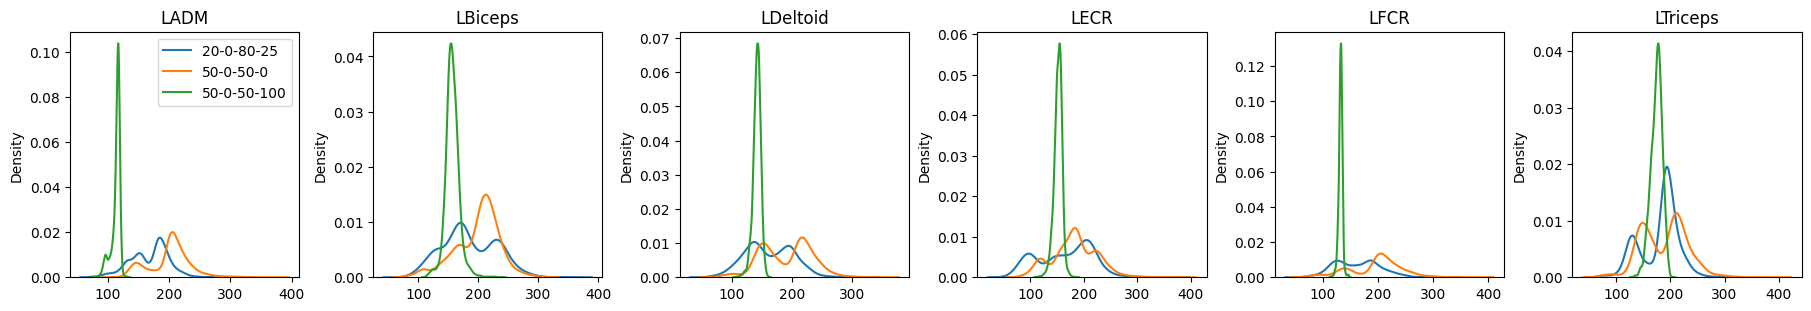

In [10]:
ind = 0
print(positions[ind])

nrows, ncols = 1, 6
fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 3, nrows * 3),
    constrained_layout=True, squeeze=False
)

for i, muscle in enumerate(model.response):
    ax = axes[0, i]
    samples = a[:, :, ind, ...].mean(axis=1)
    for j, charge in enumerate(charges):
        sns.kdeplot(samples[:, j, i], ax=ax, label=charge)
    ax.set_title(muscle)

axes[0, 0].legend();


In [18]:
ind = 0
print(f"{positions[ind]}")

for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        if l == r: continue
        l_samples = a[:, :, ind, ...].mean(axis=0)[:, i, :]
        r_samples = a[:, :, ind, ...].mean(axis=0)[:, j, :]
        pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
        print(
            f"{l}\t<\t{r}:\t{pvalue}"
        )


C7L-C7M
20-0-80-25	<	50-0-50-0:	0.01655868339747997
20-0-80-25	<	50-0-50-100:	0.9972770669479791
50-0-50-0	<	20-0-80-25:	0.9834413166025201
50-0-50-0	<	50-0-50-100:	0.9998204541013415
50-0-50-100	<	20-0-80-25:	0.002722933052020838
50-0-50-100	<	50-0-50-0:	0.00017954589865860462


### C7M-C7L


C7M-C7L


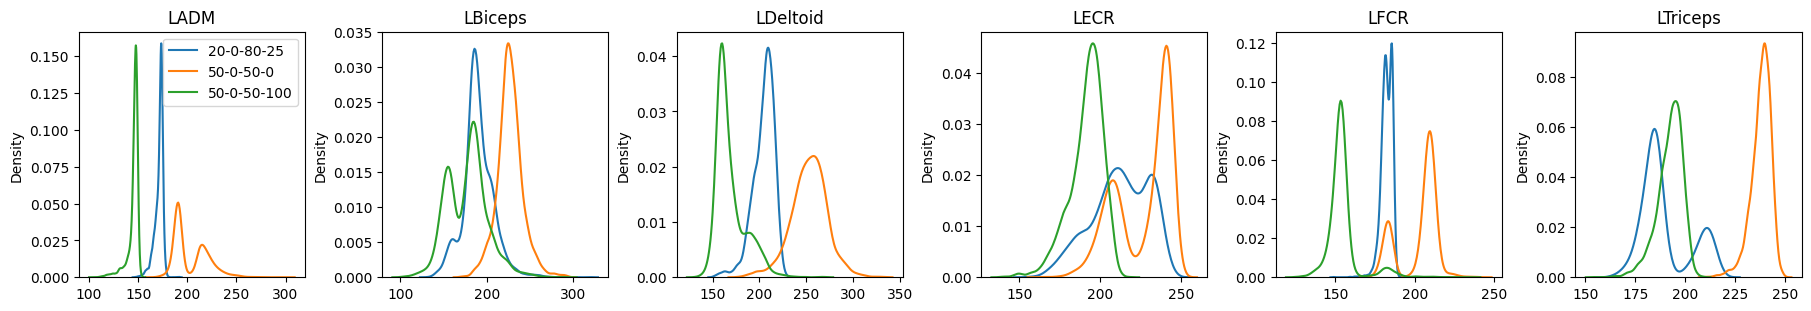

In [20]:
ind = 1
print(positions[ind])

nrows, ncols = 1, 6
fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 3, nrows * 3),
    constrained_layout=True, squeeze=False
)

for i, muscle in enumerate(model.response):
    ax = axes[0, i]
    samples = a[:, :, ind, ...].mean(axis=1)
    for j, charge in enumerate(charges):
        sns.kdeplot(samples[:, j, i], ax=ax, label=charge)
    ax.set_title(muscle)

axes[0, 0].legend();


In [21]:
ind = 1
print(f"{positions[ind]}")

for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        if l == r: continue
        l_samples = a[:, :, ind, ...].mean(axis=0)[:, i, :]
        r_samples = a[:, :, ind, ...].mean(axis=0)[:, j, :]
        pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
        print(
            f"{l}\t<\t{r}:\t{pvalue}"
        )


C7M-C7L
20-0-80-25	<	50-0-50-0:	0.00019613924377859693
20-0-80-25	<	50-0-50-100:	0.9647021304501868
50-0-50-0	<	20-0-80-25:	0.9998038607562214
50-0-50-0	<	50-0-50-100:	0.999959643225194
50-0-50-100	<	20-0-80-25:	0.035297869549813156
50-0-50-100	<	50-0-50-0:	4.0356774805902716e-05


In [22]:
a.shape


(4000, 8, 2, 3, 6)

In [28]:
for i, charge in enumerate(charges):
    print(f"\n{charge}")
    l_samples = a.mean(axis=0)[:, 0, i, :]
    r_samples = a.mean(axis=0)[:, 1, i, :]
    pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
    print(
        f"{positions[0]}\t\t<\t{positions[1]}:\t{pvalue}"
    )
    pvalue = stats.ttest_1samp(-(l_samples - r_samples), popmean=0, alternative="less", axis=(0, 1 )).pvalue
    print(
        f"{positions[1]}\t\t<\t{positions[0]}:\t{pvalue}"
    )



20-0-80-25
C7L-C7M		<	C7M-C7L:	0.03433866720964922
C7M-C7L		<	C7L-C7M:	0.9656613327903507

50-0-50-0
C7L-C7M		<	C7M-C7L:	0.024988469217498404
C7M-C7L		<	C7L-C7M:	0.9750115307825016

50-0-50-100
C7L-C7M		<	C7M-C7L:	0.00016024548851842194
C7M-C7L		<	C7L-C7M:	0.9998397545114815


In [33]:
samples = (l_samples - r_samples).reshape(-1,)
samples.shape

(48,)

In [29]:
a.shape

(4000, 8, 2, 3, 6)

In [ ]:
a[:, ]